In [1]:

%autoreload
import pylabnet.hardware.awg.zi_hdawg as zi_hdawg
from pylabnet.utils.logging.logger import LogClient

%matplotlib inline

import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import time

from IPython.display import clear_output, display

import pyvisa
from pylabnet.utils.logging.logger import LogClient
from pylabnet.network.client_server import agilent_e4405B
import pylabnet.hardware.spectrum_analyzer.agilent_e4405B as sa_hardware


import itertools as it
import pandas as pd
import seaborn as sns

from pylabnet.utils.logging.logger import LogService
from pylabnet.network.core.generic_server import GenericServer
import os
import sys
from pylabnet.utils.iq_upconversion.optimizer import IQOptimizer
from pylabnet.network.client_server import HMC_T2220

# Instantiante HDAWG

In [2]:
dev_id = 'dev8227'

# Instantiate
logger = LogClient(
    host='140.247.189.82',
    port=24001,
    module_tag=f'ZI HDAWG {dev_id}'
)

In [3]:
# Instantiate Hardware class
hd = zi_hdawg.Driver(dev_id, logger)

# Select channel grouping
hd.set_channel_grouping(0)

hd.enable_output(2)
hd.enable_output(3)

# Connect to MW client

In [4]:
# Connect to MW source client
mw_client = HMC_T2220.Client(
    host='localhost',
    port=12378
)

In [6]:
# Check that MW source is set to correct power
# mw_client.output_on()
pow = 25  # -20 dBm
mw_client.set_power(pow)
mw_client.is_output_on()
mw_client.get_power()

25.0

# Connect to Spectrum Analyzer

In [5]:
sa = agilent_e4405B.Client(
    host='localhost',
    port=12352
)

# Reset spectrum analzyer
sa.write('*RST')

(6, <StatusCode.success: 0>)

# Optimize

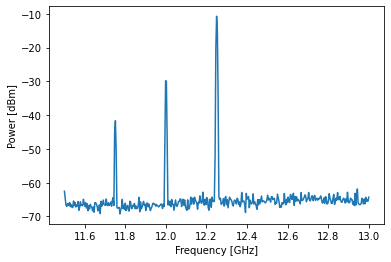

In [8]:
# See optimizer.py for a list of the keyword arguments that IQOptimizer takes
# Instantiate IQOptimizer object
opt1 = IQOptimizer(mw_client, hd, sa, 12e9,250e6,param_guess = ([90, 1, 0.75, -0.002, 0.006]), dc_i_window=0.2, dc_q_window=0.2, awg_delay_time=0.01, averages=4)

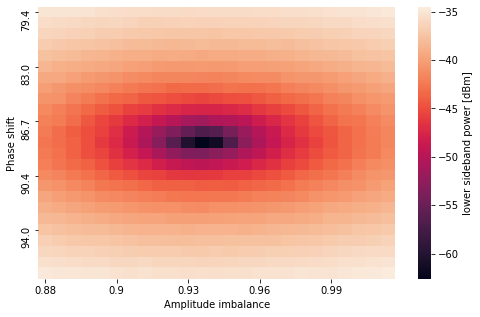

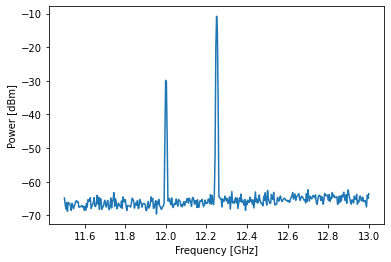

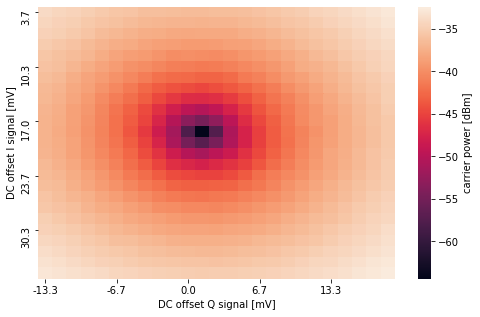

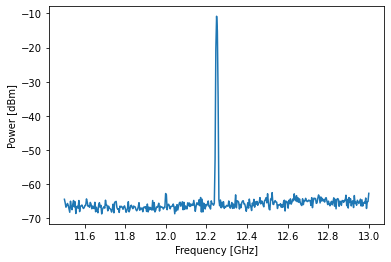

In [9]:
opt1.opt()

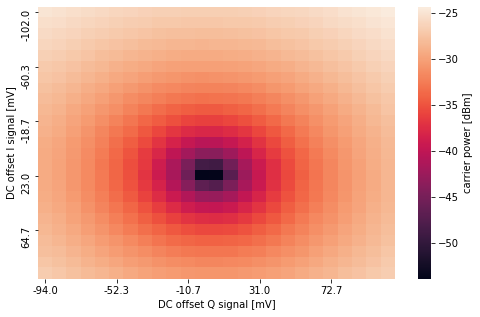

In [31]:
opt1.plot_dc_offsets_sweep(-0.002-0.1, -0.002+0.1, 0.006-0.1, 0.006+0.1, 25)

In [6]:
import pylabnet.utils.iq_upconversion.iq_upconversion_misc as ium
ium.get_power_at_harmonics(sa, 12e9, 250e6, [-1, 0, 1, 2, 3])

test


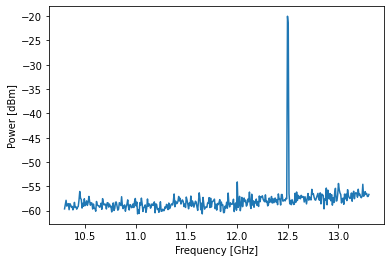

In [10]:
sa.plot_trace()

In [10]:
mw_client.output_on()

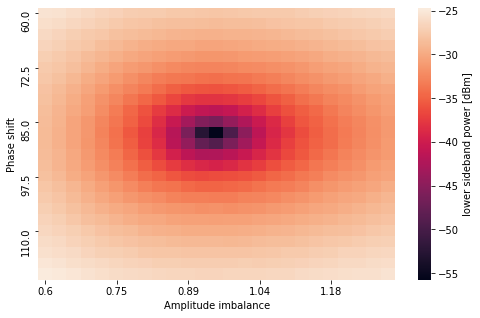

In [21]:
opt1.plot_phase_amp_sweep(60, 120, 0.6, 1.3, 25)